# New York City Taxi Fare Prediction


Here's an outline of the project:

1. Download the dataset
2. Explore & analyze the dataset
3. Prepare the dataset for ML training
4. Train hardcoded & baseline models
5. Make predictions
6. Perform feature engineering
7. Train & evaluate different models
8. Tune hyperparameters for the best model
9. Train on a GPU with the entire dataset
10. Document & publish the project online

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="new-york-city-taxi-fare-prediction")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/new-york-city-taxi-fare-prediction


'https://jovian.ai/mohitcnf95/new-york-city-taxi-fare-prediction'

## 1. Download the Dataset

- Install required libraries
- Download data from Kaggle
- View dataset files
- Load training set with Pandas
- Load test set with Pandas

### Install required libraries

In [ ]:
!pip install numpy pandas opendatasets scikit-learn xgboost --quiet

### Download data from Kaggle

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction'

In [ ]:
od.download(dataset_url)

In [ ]:
data = 'new-york-city-taxi-fare-prediction'

### View dataset files

In [ ]:
#! means shell command
!ls -lh {data} # List of files with size

In [ ]:
!wc -l {data}/train.csv # List of no of lines in train set

In [ ]:
!wc -l {data}/test.csv # List of no of lines in test set

In [ ]:
!head {data}/train.csv #few parts of training data sets

In [ ]:
!head {data}/test.csv #few parts of test data sets

**Observations:**
1. It is a supervised learning regression
2. Train Data is a 5.4 GB file with 55423856 rows
3. Test Data is very small (<10000 rows)
4. The training set has 8 columns:
    - key (a unique identifier)
    - fare_amount (target column)
    - pickup_datetime
    - pickup_longitude
    - pickup_latitude
    - dropoff_longitude
    - dropoff_latitude
    - passenger_count
5. The test set has all columns except the target column fare_amount.
6. The submission file should contain the key and fare_amount for each test sample.



In [ ]:
jovian.commit()

### Loading training sets with pandas

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the key column
- Parse pickup datetime while loading data
- Specify data types for other columns
    eg:
    - float32 for geo coordinates
    - float32 for fare amount
    - uint8 for passenger count
- Work with a 1% sample of the data (~500k rows)
- We can apply these optimizations while using pd.read_csv

In [ ]:
#importing relevant libraries
import pandas as pd
import random

In [ ]:
# Change this for sample fraction for 1% of total sample
sample_frac = 0.01

In [ ]:
selected_Col = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'. split(',')
selected_Col

In [ ]:
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
} # We are assigning the data type of the columns

def skip_row(row_idx): # we are creating a random funtion to select random rows from the dateset for our sample dataset of1%
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
df = pd.read_csv(data+"/train.csv", 
                 usecols=selected_Col, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row) # we are loading data with various arguments like no of colums to be loaded

In [ ]:
df

### Load Test Datasets

In [ ]:
test_df = pd.read_csv(data+'/test.csv', dtype = dtypes, parse_dates=['pickup_datetime'])
test_df

In [ ]:
jovian.commit()

## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

### Training Set

In [ ]:
df.info()  

In [ ]:
df.describe()

In [ ]:
df.pickup_datetime.min(), df.pickup_datetime.max()

**Observations about training data:**

- 550k+ rows, as expected
- No missing data (in the sample)
- fare_amount ranges from −52.0 to 499.0
- passenger_count ranges from 0 to 208
- There seem to be some errors in the latitude & longitude values
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.

### Test Datasets

In [ ]:
test_df.info()

In [ ]:
test_df.describe()

In [ ]:
test_df.pickup_datetime.min(), test_df.pickup_datetime.max()

**Observations about the test set:**

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun 30th 2015 (same as training set)

***We can use the ranges of the test set to drop outliers/invalid data from the training set.***

In [ ]:
jovian.commit()

What is the busiest day of the week?

In [ ]:
df['pickup_datetime'][0].weekday()

In [ ]:
def date_to_weekday(date_value): #creating a function that will return week day for the new column in dataframe
    return date_value.weekday()

In [ ]:
df['Day of the week'] = df['pickup_datetime'].apply(date_to_weekday)

In [ ]:
df['Day of the week']

In [ ]:
df.describe()

In [ ]:
df_new = df.copy()

In [ ]:
df_new['Month'] = df_new['pickup_datetime'].dt.month
df_new.head()

In [ ]:
df_new['Hour of the day'] = df_new['pickup_datetime'].dt.hour
df_new.head()

In [ ]:
df_new = df_new.drop("pickup_datetime",axis=1)
df_new.head()

In [ ]:
df_new.describe()

In [ ]:
test_df_Day = test_df.copy()

In [ ]:
def date_to_weekday(date_value): #creating a function that will return week day for the new column in dataframe
    return date_value.weekday()

In [ ]:
test_df_Day['Day of the week'] = test_df_Day['pickup_datetime'].apply(date_to_weekday)
test_df_Day['Month'] = test_df_Day['pickup_datetime'].dt.month
test_df_Day['Hour of the day'] = test_df_Day['pickup_datetime'].dt.hour  
test_df_Day.head()

In [ ]:
test_df_Day = test_df_Day.drop("pickup_datetime",axis=1) 
test_df_Day.head()

In [ ]:
test_df = test_df_Day.copy()

In [ ]:
test_df.head()

### Distance Between Pickup and Drop

In [ ]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def add_trip_distance(df_new):
    df_new['trip_distance'] = haversine_np(df_new['pickup_longitude'], df_new['pickup_latitude'], df_new['dropoff_longitude'], df_new['dropoff_latitude'])

In [ ]:
def add_trip_distance(test_df):
    test_df['trip_distance'] = haversine_np(test_df['pickup_longitude'], test_df['pickup_latitude'], test_df['dropoff_longitude'], test_df['dropoff_latitude'])

In [ ]:
%%time
add_trip_distance(df_new)

In [ ]:
%%time
add_trip_distance(test_df)

In [ ]:
df_new.head()

In [ ]:
test_df.head()

### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [ ]:
df_new.describe()

We'll use the following ranges:

- fare_amount: [Math Processing Error]500
- longitudes: -75 to -72
- latitudes: 40 to 42
- passenger_count: 1 to 6

As our test data ranges from the followings.


In [ ]:
def remove_outliers(dfn):
    return dfn[(dfn['fare_amount'] >= 1.) & 
              (dfn['fare_amount'] <= 500.) &
              (dfn['pickup_longitude'] >= -75) & 
              (dfn['pickup_longitude'] <= -72) & 
              (dfn['dropoff_longitude'] >= -75) & 
              (dfn['dropoff_longitude'] <= -72) & 
              (dfn['pickup_latitude'] >= 40) & 
              (dfn['pickup_latitude'] <= 42) & 
              (dfn['dropoff_latitude'] >=40) & 
              (dfn['dropoff_latitude'] <= 42) & 
              (dfn['passenger_count'] >= 1) & 
              (dfn['passenger_count'] <= 6)]


In [ ]:
df_new = remove_outliers(df_new)

In [ ]:
df_new.describe()

In [ ]:
jovian.commit()

In [ ]:
df_new_next = df_new.copy()
test_df_new = test_df.copy()

In [ ]:
df_new_next.to_parquet('df_new_next.parquet')

In [ ]:
test_df_new.to_parquet('test_df_new.parquet')

**Ask & Answer Questions about the dataset:**
1. What is the busiest day of the week?
2. What is the busiest time of the day?
3. In which month are fares the highest?
4. Which pickup locations have the highest fares?
5. Which drop locations have the highest fares?
6. What is the average ride distance?

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
      - Training
      - Validation
      - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data.

Since the test set and training set have the same date ranges, we can pick a random 20% fraction. (validation set should be as similar to the test set or real-world data as possible i.e. the evaluation metric score of a model on validation & test sets should be very close, otherwise you're shooting in the dark.)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(df_new, test_size = 0.2, random_state= 42) # Splitting train data into train data and validation data

In [ ]:
len(train_df), len(val_df)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)>

In [ ]:
jovian.commit()

### Extract Inputs and Outputs

In [ ]:
train_df.columns

In [ ]:
test_df.columns

In [ ]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'Day of the week', 'Month', 'Hour of the day',
       'trip_distance']

In [ ]:
target_cols = ['fare_amount']

### Training

In [ ]:
train_inputs = train_df[input_cols]

In [ ]:
train_inputs.head()

In [ ]:
train_targets = train_df[target_cols]

In [ ]:
train_targets

### Validation Data

In [ ]:
val_inputs = val_df[input_cols]

In [ ]:
val_inputs.head()

In [ ]:
val_targets = val_df[target_cols]

In [ ]:
val_targets

### Testing Data

In [ ]:
test_inputs = test_df[input_cols]

In [ ]:
test_inputs.head()

In [ ]:
jovian.commit()

## 4. Train & Evaluate Different Models

We'll train each of the following:
- Linear Regression
- Random Forests
- Gradient Boosting
- Train Ridge
- SVM
- KNN
- Decision Tree model

Let's define a helper function to evaluate models and generate test predictions

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#creating a helper function to predict our values and calculate Mean square error
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse, train_preds, val_preds

In [ ]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Linear Regression (Ridge Regression)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
model_ridge = Ridge(random_state = 42)

In [ ]:
%%time
model_ridge.fit(train_inputs, train_targets)

In [ ]:
evaluate(model_ridge)

Ridge Model was able to get to an RMSE of $5.2

In [ ]:
predict_and_submit(model_ridge, 'ridge_model_submission.csv')

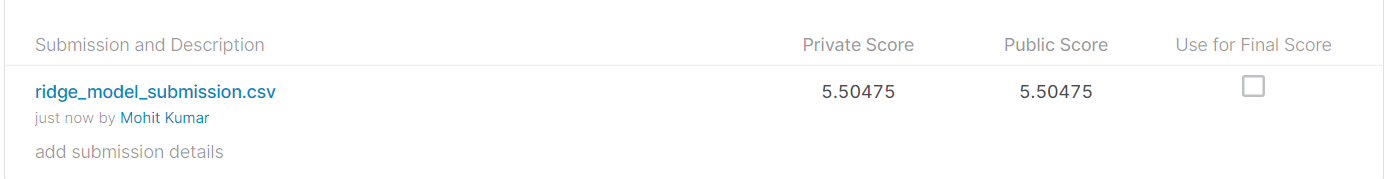

In [ ]:
jovian.commit()

### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model_Randomforest = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [ ]:
%%time
model_Randomforest.fit(train_inputs, train_targets)

In [ ]:
evaluate(model_Randomforest)

In [ ]:
predict_and_submit(model_Randomforest, 'RandomForest_Model_submission.csv')

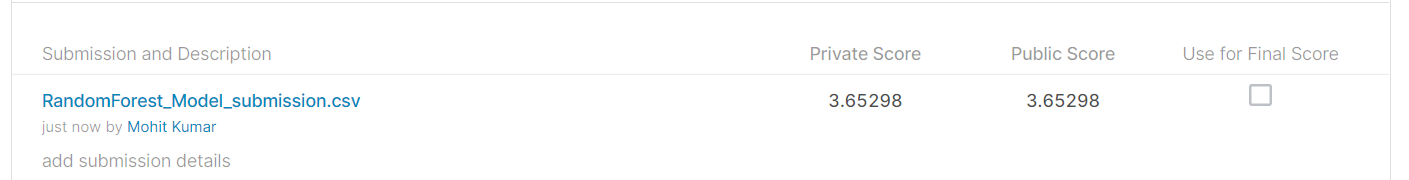

In [ ]:
jovian.commit()

### Gradient Boosting Model

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model_GradientBoosting = XGBRegressor(random_state = 42, n_jobs = -1, objective = 'reg:squarederror')

In [ ]:
%%time
model_GradientBoosting.fit(train_inputs, train_targets)

In [ ]:
evaluate(model_GradientBoosting)

In [ ]:
predict_and_submit(model_GradientBoosting, 'GradientBoosting_Model_submission.csv')

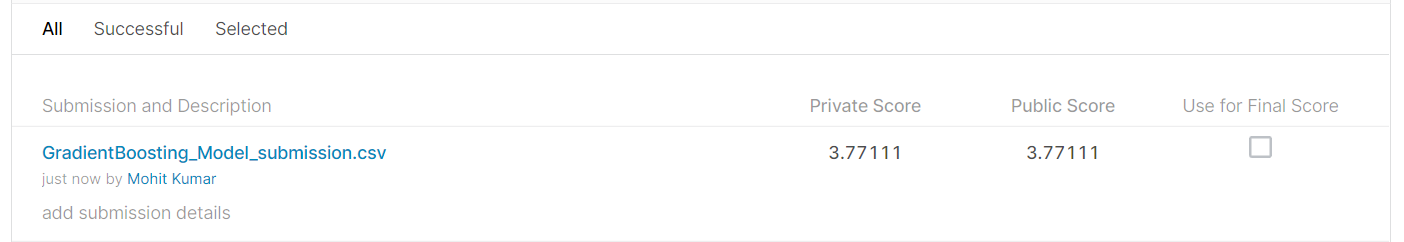

In [ ]:
jovian.commit()